# Least Square Meshes

Suppose you have a mesh with ugly triangles and you want to make it nicer. Have these beautiful equilateral triangles. Or, you want to deform a mesh by dragging on some control points. Or, maybe you want to compress your meshdata on a server, and only send parts of it, but display all of it on the client.

How would you go about achieving this?

One solution that is a basis for **lots** of usefull methods for working with 3d/2d/whatever meshes are least-square meshes. Let's have a look at them!

First, let's generate us a 2d mesh:

In [72]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (20,10)

# MOVE ALL THIS STUFF TO HELPER FILE

def generate_square(x, y, l=1):    
    return {
        "vertices": (
            (x, y),
            (x, y + l),
            (x + l, y),
            (x + l, y + l),
        ),
        "edges": (
            (0,1),
            (0,2),
            (1,2),
            (2,3),
            (1,3)
        )
    }

def plot_mesh(mesh, highlight_verts=[], ax=plt, c=None, cmap=None):
    verts = mesh["vertices"]
    edges = mesh["edges"]

    x = [vert[0] for vert in verts]
    y = [vert[1] for vert in verts]

    for edge in edges:
        vertexA = verts[edge[0]]
        vertexB = verts[edge[1]]

        ax.plot(
            [vertexA[0], vertexB[0]],
            [vertexA[1], vertexB[1]],
            'k'
        )
    
    if c is None:
        ax.plot(x,y,'og')
    elif c is not None or cmap is not None:
        ax.scatter(x,y, c=c, cmap=cmap)
    
    if highlight_verts:
        x_highlight = [vert[0] for idx, vert in enumerate(verts) if idx in highlight_verts]
        y_highlight = [vert[1] for idx, vert in enumerate(verts) if idx in highlight_verts]
        
        ax.plot(x_highlight,y_highlight,'or')

def merge_meshes(meshes):
    offset = 0
    
    new_verts = []
    new_edges = []
    
    for mesh in meshes:
        verts = mesh["vertices"]
        edges = mesh["edges"]
        
        for edge in edges:
            vertA = verts[edge[0]]
            vertB = verts[edge[1]]
            
            if vertA in new_verts:
                idxA = new_verts.index(vertA)
            else:
                idxA = len(new_verts)
                new_verts.append(vertA)
            
            if vertB in new_verts:
                idxB = new_verts.index(vertB)
            else:
                idxB = len(new_verts)
                new_verts.append(vertB)
            
            new_edge = (idxA, idxB)
            
            if new_edge not in new_edges:
                new_edges.append(new_edge)
    
    return {
        "vertices": new_verts,
        "edges": new_edges
    }

def disturb_mesh(mesh, amount=1):
    verts = np.array(mesh["vertices"], dtype=np.float64)
    num_verts = len(verts)
    
    offsets = amount * np.random.rand(num_verts, 2)
    
    verts += offsets
    
    return {
        "vertices": verts.tolist(),
        "edges": mesh["edges"]
    }

def generate_grid(size=5):
    rects = []

    for i in range(size):
        for j in range(size):
            rects.append(generate_square(i,j))

    return merge_meshes(rects)

Vertices: 36, Edges: 85


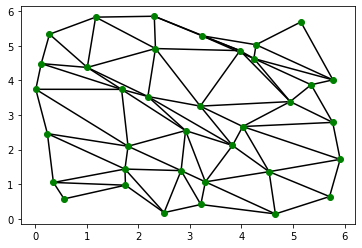

In [33]:
grid = generate_grid()
grid = disturb_mesh(grid)

plot_mesh(grid)

print("Vertices: {}, Edges: {}".format(len(grid["vertices"]), len(grid["edges"])))

This mesh can be represented with two matrices:

- $V$ which represents the positions of the vertices.
- $E$ which represents the edges.

$$V = \begin{pmatrix} \vec{v_1} \\ \vec{v_2} \\ \vdots \end{pmatrix} = \begin{pmatrix} x_1 & y_1 \\ x_2 & y_2 \\ \vdots \end{pmatrix}$$


$$ E = \begin{bmatrix}
0 & 0 & 1 & \dots \\
0 & 0 & 0 & \dots \\
1 & 0 & 0 & \dots \\
\vdots
\end{bmatrix} $$

Hereby an entry $E_{ij}$ in Matrix $E$ at row $i$ and column $j$ means "Vertex $i$ is connected to vertex $j$".

---

## Fairing a Mesh

Now, to actually do some mesh fairing, we need to define some anchor vertices. These are the ones we want to stay put, as much as possible. We will go outwards from them, trying to figure out the positions of all the other vertices.

These anchors can later be used as control points to deform a mesh. In this case, let's use the border vertices:

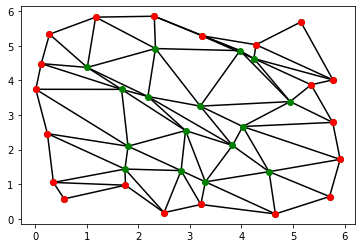

In [34]:
def get_border_verts(mesh):
    edges = mesh["edges"]
    vert_degrees = {}
    
    for edge in edges:
        for vert in edge:
            if vert not in vert_degrees:
                vert_degrees[vert] = 0

            vert_degrees[vert] += 1
    
    border_verts = []
    for vert in vert_degrees:
        if vert_degrees[vert] < 6:
            border_verts.append(vert)
    
    return border_verts, vert_degrees

border_verts, degrees = get_border_verts(grid)
plot_mesh(grid, highlight_verts=border_verts)

Imagine the mesh getting deflated – like a net, lying on the ground. The information about connections is still there, but no information about where in space specific vertices should be. So we basically know $E$, but have no idea about $V$. Now w/ the anchor points, we "rehydrate" the net. We take in positional information, that then gets propagated to all the vertices that have had their positions removed.

Let's see it in action, and then think about how this was calculated.

---
# TMP

In [35]:
def return_laplace(mesh, anchor_weight=1):
    verts = np.copy(mesh["vertices"])
    edges = mesh["edges"]
    
    _, degrees = get_border_verts(mesh)

    num_verts = len(verts)

    A = np.eye(num_verts)
    b = np.zeros((num_verts, 2))
    
    I = np.eye(num_verts)
    E = np.zeros((num_verts, num_verts))
    N = np.zeros((num_verts, num_verts))
    
    for edge in edges:
        idxA = edge[0]
        idxB = edge[1]
        
        E[idxA, idxB] = 1
        E[idxB, idxA] = 1
        
        N[idxA, idxA] = degrees[idxA]
        N[idxB, idxB] = degrees[idxB]
    
    
    L = I - np.linalg.inv(N) @ E

    return L

In [40]:
X = np.array(grid["vertices"])
L = return_laplace(grid)

In [50]:
laplace_applied = L@X
grid_new = {}
grid_new["edges"] = grid["edges"]
grid_new["vertices"] = laplace_applied

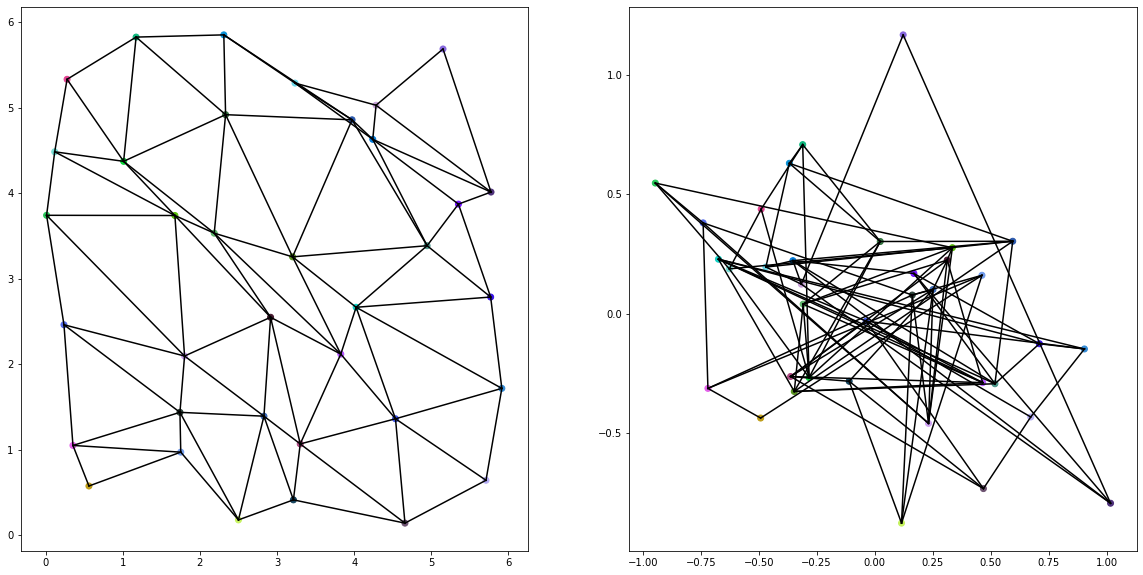

In [73]:
num_verts = laplace_applied.shape[0]
colors = [
    (np.random.rand(), np.random.rand(), np.random.rand()) for _ in range(num_verts)
]

fig, axes = plt.subplots(ncols=2)

plot_mesh(grid, c=colors, ax=axes[0])
plot_mesh(grid_new, c=colors, ax=axes[1])

Reconstructing the mesh from its frequencies.. So let's get the eigenvalues of the laplace-matrix

In [81]:
eivals, eivecs = np.linalg.eig(L)

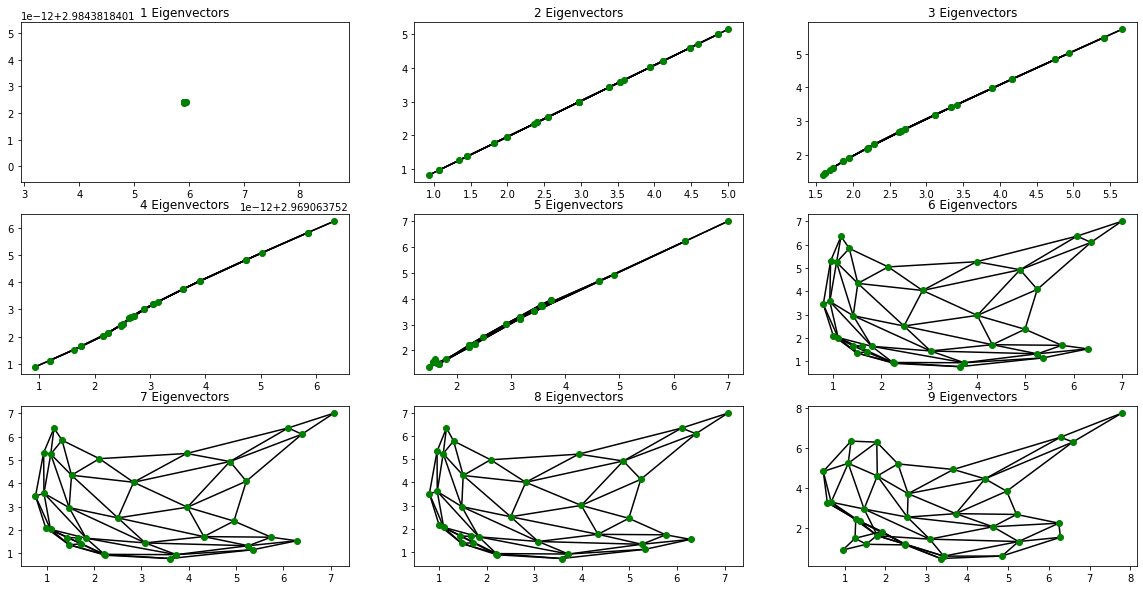

In [120]:
def reconstruct(X, eivecs, max_eivecs=1):
    reconstructed_X = np.zeros_like(X)

    for i in range(max_eivecs):
        reconstructed_X += (X.T @ eivecs[:,i]) * eivecs[:,i].reshape((-1,1))

    grid_new = {}
    grid_new["edges"] = grid["edges"]
    grid_new["vertices"] = reconstructed_X
    
    return grid_new

fig, axes = plt.subplots(ncols=3, nrows=3)

n_eivecs = 1
for row in range(3):
    for col in range(3):
        plot_mesh(reconstruct(X, eivecs, max_eivecs=n_eivecs),  ax=axes[row, col])
        axes[row, col].set_title("{} Eigenvectors".format(n_eivecs))
        n_eivecs += 1

---

L:
 [[ 1.   -0.5  -0.5  ...  0.    0.    0.  ]
 [-0.25  1.   -0.25 ...  0.    0.    0.  ]
 [-0.25 -0.25  1.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.   -0.25  0.  ]
 [ 0.    0.    0.   ... -0.25  1.   -0.25]
 [ 0.    0.    0.   ...  0.   -0.5   1.  ]]
Laplacian: [[ 1.   -0.5  -0.5  ...  0.    0.    0.  ]
 [-0.25  1.   -0.25 ...  0.    0.    0.  ]
 [-0.25 -0.25  1.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.   -0.25  0.  ]
 [ 0.    0.    0.   ... -0.25  1.   -0.25]
 [ 0.    0.    0.   ...  0.   -0.5   1.  ]]
L:
 [[ 1.   -0.5  -0.5  ...  0.    0.    0.  ]
 [-0.25  1.   -0.25 ...  0.    0.    0.  ]
 [-0.25 -0.25  1.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.   -0.25  0.  ]
 [ 0.    0.    0.   ... -0.25  1.   -0.25]
 [ 0.    0.    0.   ...  0.   -0.5   1.  ]]
Laplacian: [[ 1.   -0.5  -0.5  ...  0.    0.    0.  ]
 [-0.25  1.   -0.25 ...  0.    0.    0.  ]
 [-0.25 -0.25  1.   ...  0.    0.    0.  ]
 ...
 [ 0.    0.    0.   ...  1.   -0.25  0.  ]
 

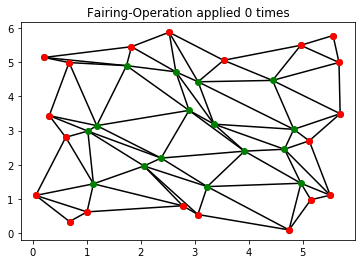

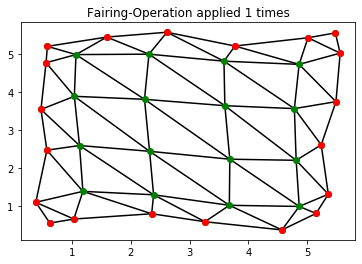

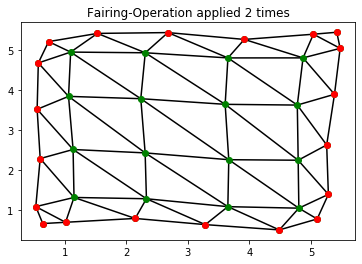

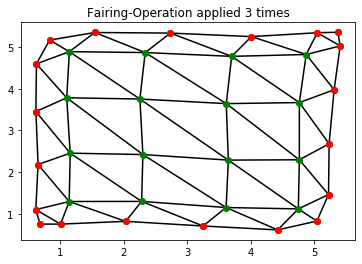

In [4]:
def laplace_mesh(mesh, anchor_indices, anchor_weight=1):
    verts = np.copy(mesh["vertices"])
    edges = mesh["edges"]
    
    _, degrees = get_border_verts(mesh)

    num_verts = len(verts)

    A = np.eye(num_verts)
    b = np.zeros((num_verts, 2))
    
    I = np.eye(num_verts)
    E = np.zeros((num_verts, num_verts))
    N = np.zeros((num_verts, num_verts))
    
    for edge in edges:
        idxA = edge[0]
        idxB = edge[1]
        
        E[idxA, idxB] = 1
        E[idxB, idxA] = 1
        
        N[idxA, idxA] = degrees[idxA]
        N[idxB, idxB] = degrees[idxB]
    
    
    L = I - np.linalg.inv(N) @ E
    print("L:\n", L)

    # Add fairing constraints
    for edge in edges:
        idxA = edge[0]
        idxB = edge[1]

        A[idxA, idxB] = -1/degrees[idxA]
        A[idxB, idxA] = -1/degrees[idxB]

    F = np.zeros((len(anchor_indices), num_verts))
    b2 = np.zeros((len(anchor_indices), 2))
    
    # Add anchor constraints
    for idx, anchor_idx in enumerate(anchor_indices):
        F[idx,anchor_idx] = anchor_weight
        b2[idx,:] = verts[anchor_idx] * anchor_weight

    AA = np.vstack((A, F))
    bb = np.vstack((b, b2))
    
    print("Laplacian:", A)

    new_vert_positions = np.linalg.solve(AA.T@AA, AA.T@bb)
    
    return {
        "vertices": new_vert_positions.tolist(),
        "edges": edges
    }


grid0 = grid
grid1 = laplace_mesh(grid0, border_verts)
grid2 = laplace_mesh(grid1, border_verts)
grid3 = laplace_mesh(grid2, border_verts)

grids = [
    grid0,
    grid1,
    grid2,
    grid3
]

for i, agrid in enumerate(grids):
    if i > 0:
        plt.figure()
    plot_mesh(agrid, highlight_verts=border_verts)
    plt.title("Fairing-Operation applied {} times".format(i))

We can see just how quickly the algorithm distributes the vertices in a fair way. The triangles are nice to look at! (Also note that our anchors got moved, too. We will get to that a bit later).

Now to prove to you, that this indeed only needs the locations of the anchor points, let's set all the other vertices to $v_i = \begin{pmatrix}0\\ 0\end{pmatrix}$

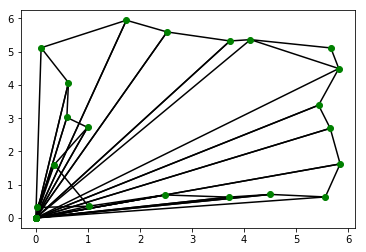

In [7]:
def make_mesh(verts, edges):
    return {
        "vertices": verts,
        "edges": edges
    }

def clone_mesh(mesh):
    verts = np.copy(mesh["vertices"])
    edges = np.copy(mesh["edges"])
    
    return make_mesh(verts, edges)

def mesh_deflate_except(mesh, anchorverts):
    cloned_mesh = clone_mesh(mesh)
    
    for i, vert in enumerate(cloned_mesh["vertices"]):
        if i not in anchorverts:
            cloned_mesh["vertices"][i] = (0,0)
    
    return cloned_mesh

grid_deflated = mesh_deflate_except(grid, border_verts)

plot_mesh(grid_deflated)

And now, let's apply the operation:

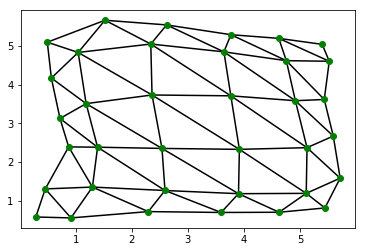

In [8]:
grid_inflated = laplace_mesh(grid_deflated, border_verts)

plot_mesh(grid_inflated)

Isn't that crazy? The entire internal structure of the mesh has been reconstructed, based on a few known positions. And smoothly too.

So, how did we do it?

## The mechanism

First, let's think of what it means for a mesh to have a "nice", "fair" structure. If you're a 3D-modeler, you're probably thinking about uniform triangles, with similar interior angles, something like this:

![A fair mesh](fair.png)

This also happens to be a "nice" structure from a computational standpoint, saving you from numerical instabilities. So we'll go ahead with this.

Now, since we're working with vertex positions and edges, we need to define this fairness in terms of vertex positions (since we don't wanna change the connections). Let's derive this from a picture of the perfectly fair mesh:

![One Ring Neighbourhood 1](neighbours_1.png)

Just look at it for a while, until you can formulate the fairness you see in terms of positions. How is the central vertex dependent on it's neighbours?

Did you find it?

It's really simple, and doesn't need much maths to describe it: The central vertex lies in the middle of it's neighbours. It's position is the mean of the position of its neighbours (we call these directly-connected neighbours the "1-ring neighbourhood").

So let this be our fairing condition:

$$ \vec{v_i} = \frac{1}{N_i} \sum^{neighbours(v_i)}{\vec{v_j}} $$

with $N_i$ being the number of 1-ring neighbours of $v_i$, and $v_j$ being vertices drawn from the 1-ring neighbourhood around $v_i$.

---

To compute this efficiently, we need to rewrite this in matrix-vector form. So let's first expand this naively, and then simplify it (with $j$ being the neighbours of $v_1$, $k$ being the neighbours of $v_2$ and so on):

$$ \begin{bmatrix}
\vec{v_1} \\
\vec{v_2} \\
\vdots \end{bmatrix} = \begin{bmatrix} \frac{1}{N_1} \sum{\vec{v_j}} \\
\frac{1}{N_2} \sum{\vec{v_k}} \\
\vdots \end{bmatrix} $$

We simplify the left side and factor out the $N$-terms:

$$ V = \begin{bmatrix}
\frac{1}{N_1} & 0 & \dots \\
0 & \frac{1}{N_2} & \dots \\
\vdots & \vdots & \ddots \\
\end{bmatrix}
\begin{bmatrix}
\sum{\vec{v_j}}\\
\sum{\vec{v_k}}\\
\vdots \end{bmatrix}$$

How can we replace that ugly sum-vector on the right? Well, Matrix-Vector notation lends itself very nicely to sums. The vector specifies which elements we want to sum, and the matrix (or row-vector) defines in what combination we want to sum them:

$$ \begin{bmatrix}
1 & 0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
v_{1}\\
v_{2}\\
v_{3}\\
v_{4}
\end{bmatrix}
=v_{1} +v_{4}
$$

So we only need to know the combination matrix to get the appropriate sums... Hmmm... We already have that!

Remember at the top of the page? $E$? Our matrix that defines which vertex is connected to which? Exactly what we need!

So we can replace the sums with $EV$:

$$\begin{bmatrix}
\sum{\vec{v_j}}\\
\sum{\vec{v_k}}\\
\vdots \end{bmatrix}=
\underbrace{\begin{bmatrix}
0 & 1 & 1 & \dotsc \\
1 & 0 & 1 & \dotsc \\
1 & 1 & 0 & \dotsc \\
\vdots  & \vdots  & \vdots  & \ddots 
\end{bmatrix}}_E
\underbrace{\begin{bmatrix}
v_{1}\\
v_{2}\\
v_{3}\\
\vdots 
\end{bmatrix}}_V
$$

Thus we receive:

$$V=\underbrace{\begin{bmatrix}
\frac{1}{N_{1}} &  &  & \\
 & \frac{1}{N_{2}} &  & \\
 &  & \frac{1}{N_{3}} & \\
 &  &  & \ddots 
\end{bmatrix}}_{N^{-1}}\underbrace{\begin{bmatrix}
0 & 1 & 1 & \dotsc \\
1 & 0 & 1 & \dotsc \\
1 & 1 & 0 & \dotsc \\
\vdots  & \vdots  & \vdots  & \ddots 
\end{bmatrix}}_{E}\underbrace{\begin{bmatrix}
v_{1}\\
v_{2}\\
v_{3}\\
\vdots 
\end{bmatrix}}_{V}
$$

Now to solve this, we can reformulate this into a usual system of linear equations: $Ax = b$ with $A = (N^{-1}E-I)$,  $x=V$ and $b=0$:

$$(N^{-1}E-I)V=0
$$

But of course this doesn't get us far, the obvious answer here is $0$. After all, we're just solving for the position of vertices that lie in the center of their neighbours. This is certainly true if all vertices are at $(0,0)$.

---

So how do we get this more interesting?

We need to add our previous knowledge about existing vertex positions. Some **constraints** that don't allow the simple solution of zero.

This is where our anchor points come in. These points will add prior knowledge, or wishes for positions respectively. I will name our anchors $$U\ =\ \begin{bmatrix}
u_{1}\\
u_{2}\\
u_{3}\\
\vdots 
\end{bmatrix}$$

Let's say we want to keep the positions of vertex 1 and 2. This leads us to the following constraint:

$$\begin{bmatrix}
1 & 0 & 0 & \dotsc \\
0 & 1 & 0 & \dotsc 
\end{bmatrix}\begin{bmatrix}
v_{1}\\
v_{2}\\
v_{3}\\
\vdots 
\end{bmatrix} =\begin{bmatrix}
u_{1}\\
u_{2}\\
\end{bmatrix}$$

Let's call this new matrix of constraints $F$ and the right side as $b_k$. We can just tack it onto $A$ (and $b$ respectively) and suddenly our system solves for real values!

$$A\ =\ \begin{bmatrix}
A\\
F
\end{bmatrix} ,\ b=\begin{bmatrix}
0\\
b_{k}
\end{bmatrix}
$$

This system now has more constraints than unkowns and as such can be solved with the least squares approach (Normal equation $A^TAx=A^Tb$). This however doesn't conserve the positions exactly, as it tries to satisfy all constraints well, loosing precision in the meantime.

---

Now, let's get a little more control over this. Let's add some preference for either fairness or precision: A weight that gets multiplied with the positional constraints $F$ and $b_k$.

We'll measure the $L_2$ distance between the positions of the original mesh and the smoothed one and compute the mean over that. This way we can put a number on how well the positions are kept.

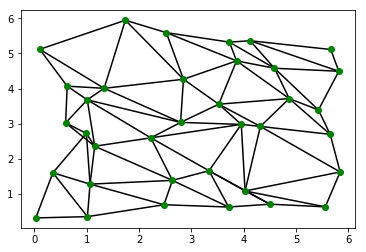

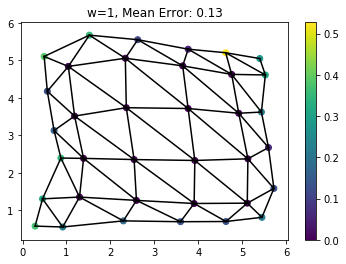

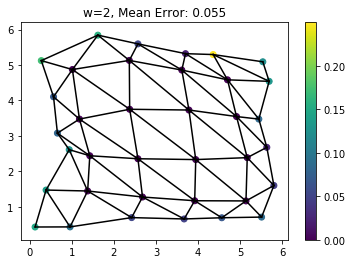

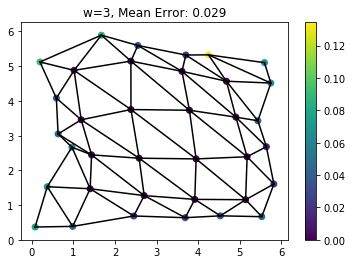

In [9]:
viridis = plt.get_cmap("viridis")
    
def f(w):
    laplaced_mesh = laplace_mesh(grid_deflated, border_verts, anchor_weight=w)
    
    errors = []
    for i, vertLaplace in enumerate(laplaced_mesh["vertices"]):
        if i not in border_verts:
            errors.append(0)
            continue
        
        vertLaplace = vertLaplace
        vertOriginal = grid_deflated["vertices"][i]

        errors.append(
            np.linalg.norm(vertLaplace - vertOriginal)
        )
    
    plot_mesh(
        laplaced_mesh,
        cmap=viridis,
        c=errors)
    plt.colorbar()
    plt.title("w={}, Mean Error: {:.2}".format(w, np.mean(errors)))

plot_mesh(grid)

for i in range(1,4):
    plt.figure()
    f(i)

As you can see, the more we increase the weights of the anchor points, the more precise their position is kept. At the same time, the mesh isn't faired as much, since it stays closer to the original.

This, in a nutshell is, what **least squares meshes** are. An approximation of some anchor vertices, combined with a propagating constraint that moves all unconstrained vertices. And this propagation condition (also the fairing condition) we used is usually called the **laplace-operator** and is useful for lots of things!

Now to go back to the beginning, you've seen how it can be used to fair meshes. But what about the other two? Compressing meshes and deforming meshes?

The compression works by not having to send/store the positions of all non-anchor points. There are clever algorithms to chose the best anchor points to be able to regain the original mesh as closely as possible.

The deformation works by not using existing positions as anchorpoints, but by letting the user move anchor points. As the change in position gets propagated from the anchor to the rest of the mesh, it gets deformed.

cya,

max